# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [2]:
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


RANDOM_STATE = 80523

## Загрузим

In [3]:
try:
    data_arc = pd.read_csv('~/Документы/datasets/final_project/data_arc_new.csv')
    data_bulk = pd.read_csv('~/Документы/datasets/final_project/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('~/Документы/datasets/final_project/data_bulk_time_new.csv')
    data_gas = pd.read_csv('~/Документы/datasets/final_project/data_gas_new.csv')
    data_temp = pd.read_csv('~/Документы/datasets/final_project/data_temp_new.csv')
    data_wire = pd.read_csv('~/Документы/datasets/final_project/data_wire_new.csv')
    data_wire_time = pd.read_csv('~/Документы/datasets/final_project/data_wire_time_new.csv')
    print('local data ready')
    print('')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
    print('cloud data ready')
    print('')
finally:
    dataframes = [data_arc, data_bulk, data_bulk_time, 
                  data_gas, data_temp, data_wire, data_wire_time]
    for i in dataframes:
        display(i.info(), i.head())
        print('')
        print('')

local data ready

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обработаем

На этом шаге столкнулась со следующими проблемами:
* некоторые ключи в порядке пропущены
* есть пропуски в замерах целевого признака, да и в других тоже
* часть данных не совместить из-за отсутствия совпадения по ключам

Для удобства встраивания в какой-либо API (для бизнеса) сразу сделала все в виде трех функций: первая создает базовую табличку с таргетом и целевым, а также берет общее время работы с котлом, вторая считает полную мощность и добавляет данные к нашей новой табличке, третья обрабатывает райки, булки и газ, после чего также присоединяет к табличке. 


In [4]:
def frame_maker(data_temp):
    
    data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
    new_data = pd.DataFrame()
    keys = []
    starts = []
    finals = []
    duration = []
    data_temp = data_temp.fillna(0)
    
    for k in tqdm(data_temp['key'].unique()):
        
        if len(data_temp[data_temp['key'] == k]) >= 2:
            s = data_temp.loc[data_temp['key'] == k, 'Температура'].values[0]
            f = data_temp.loc[data_temp['key'] == k, 'Температура'].values[-1]
            t_f = data_temp.loc[data_temp['key'] == k, 'Время замера'].iloc[-1]
            t_s = data_temp.loc[data_temp['key'] == k, 'Время замера'].iloc[0]
            
            if f != 0:
                keys.append(k)
                starts.append(s)
                finals.append(f)
                duration.append(t_f - t_s)
            
    new_data['key'] = keys
    new_data['Начальная температура'] = starts           
    new_data['Конечная температура'] = finals
    new_data['Продолжительность работы с котлом'] = duration
    new_data['Продолжительность работы с котлом'] = (new_data['Продолжительность работы с котлом']).dt.total_seconds()

    return new_data

In [5]:
data_full = frame_maker(data_temp)

  0%|          | 0/3216 [00:00<?, ?it/s]

In [6]:
def power_maker(data_arc, data_full):
    data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
    data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
    data_arc['Время нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
    data_arc['Время нагрева'] = data_arc['Время нагрева'].dt.total_seconds()
    
    new_data = pd.DataFrame()
    power_count = []
    power_reactive = []
    duration = []
    keys = []
    
    for k in tqdm(data_arc['key'].unique()):
        active_power = sum(data_arc.loc[data_arc['key'] == k, 'Активная мощность'])
        reactive_power = sum(data_arc.loc[data_arc['key'] == k, 'Реактивная мощность'])
        full_power = ((active_power ** 2 + reactive_power ** 2) ** 0.5)
        total = sum(data_arc.loc[data_arc['key'] == k, 'Время нагрева'])
        power_count.append(full_power)
        power_reactive.append(reactive_power)
        keys.append(k)
        duration.append(total)
    
    new_data['key'] = keys
    new_data['Полная мощность'] = power_count
    new_data['Реактивная мощность'] = power_reactive
    new_data['Время нагрева'] = duration
    data_full = data_full.merge(new_data, how='inner', on='key')
    
    return data_full

In [7]:
data_full = power_maker(data_arc, data_full)

  0%|          | 0/3214 [00:00<?, ?it/s]

In [8]:
def dopant_maker(data_full, data_bulk, data_gas, data_wire):
    data_bulk = data_bulk.fillna(0)
    data_gas = data_gas.fillna(0)
    data_wire = data_wire.fillna(0)
    total_bulk = []
    key_bulk = []
    total_wire = []
    key_wire = []
    bulk_data = pd.DataFrame()
    wire_data = pd.DataFrame()
    
    for s in tqdm(range(len(data_bulk))):
        total = sum(data_bulk.iloc[s, 1:-1])
        key = data_bulk['key'][s]
        key_bulk.append(key)
        total_bulk.append(total)
    
    for i in tqdm(range(len(data_wire))):
        total = sum(data_wire.iloc[i, 1:-1])
        key = data_wire['key'][i]
        total_wire.append(total)
        key_wire.append(key)
    
    bulk_data['key'] = key_bulk
    bulk_data['Сыпучие материалы'] = total_bulk
    wire_data['key'] = key_wire
    wire_data['Проволочные материалы'] = total_wire
    
    data_full = data_full.merge(wire_data, on='key', how='inner')
    data_full = data_full.merge(bulk_data, on='key', how='inner')
    data_full = data_full.merge(data_gas, on='key', how='inner')
    data_full = data_full.merge(data_bulk, on='key', how='inner')
    data_full = data_full.merge(data_wire, on='key', how='inner')
    
    return data_full

In [9]:
data_full = dopant_maker(data_full, data_bulk, data_gas, data_wire)

  0%|          | 0/3129 [00:00<?, ?it/s]

  0%|          | 0/3081 [00:00<?, ?it/s]

In [10]:
display(data_full.info(), data_full.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   key                                2329 non-null   int64  
 1   Начальная температура              2329 non-null   float64
 2   Конечная температура               2329 non-null   float64
 3   Продолжительность работы с котлом  2329 non-null   float64
 4   Полная мощность                    2329 non-null   float64
 5   Реактивная мощность                2329 non-null   float64
 6   Время нагрева                      2329 non-null   float64
 7   Проволочные материалы              2329 non-null   float64
 8   Сыпучие материалы                  2329 non-null   float64
 9   Газ 1                              2329 non-null   float64
 10  Bulk 1                             2329 non-null   float64
 11  Bulk 2                             2329 non-null   float

None

,key,Начальная температура,Конечная температура,Продолжительность работы с котлом,Полная мощность,Реактивная мощность,Время нагрева,Проволочные материалы,Сыпучие материалы,Газ 1,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,1714.0,3.716640,2.142821,1098.0,60.059998,399.0,29.749986,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265.0,2.586371,1.453357,811.0,96.052315,428.0,12.555561,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753.0,5.014163,2.937457,655.0,91.160157,391.0,28.554793,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220.0,3.399456,2.056992,741.0,89.063515,441.0,18.841219,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536.0,2.815155,1.687991,869.0,98.352796,432.0,5.413692,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Исследуем

Проведем анализ данных по графикам

### Продолжительность работы с котлом

/home/brshk-shaun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


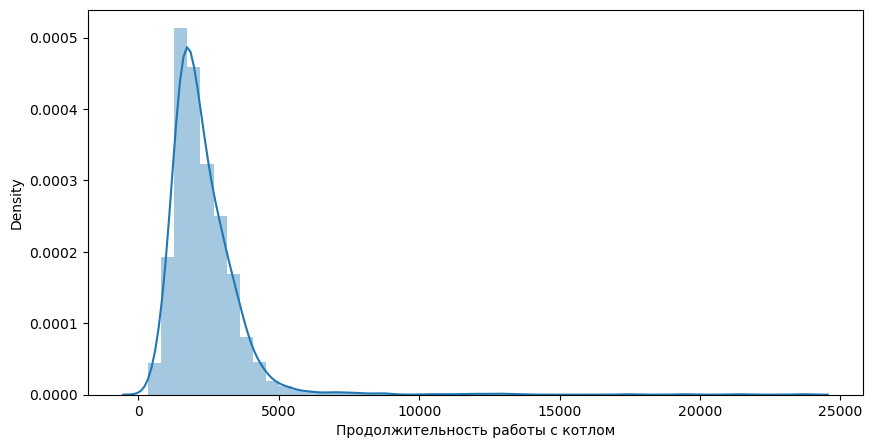

In [11]:
plt.figure(figsize=(10, 5))
sns.distplot(data_full['Продолжительность работы с котлом'])
plt.show()

### Конечная температура
На графике мы видим, что некоторые данные ниже температуры варки - удалим их

/home/brshk-shaun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


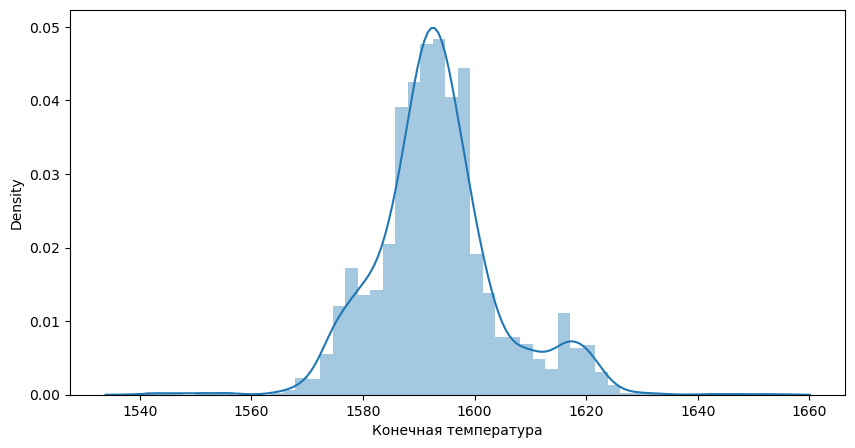

In [12]:
plt.figure(figsize=(10, 5))
sns.distplot(data_full['Конечная температура'])
plt.show()

In [13]:
data_full = data_full[data_full['Конечная температура'] > 1450]

/home/brshk-shaun/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


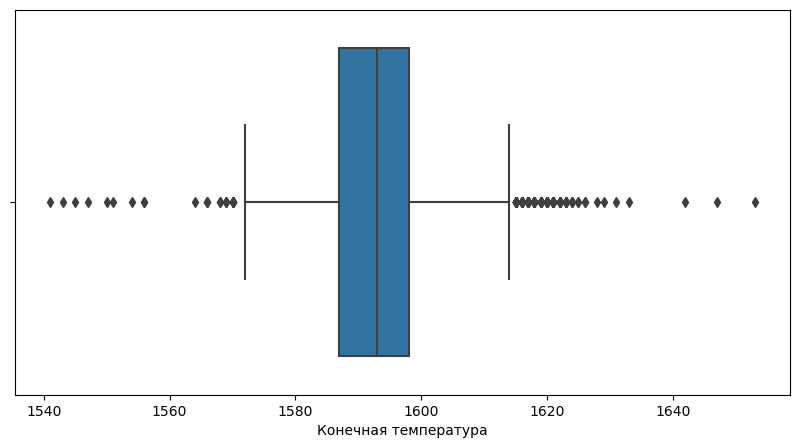

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(data_full['Конечная температура'])
plt.show()

### Реактивная мощность
Реактивная мощность -700 явный выброс, удалим его

/home/brshk-shaun/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


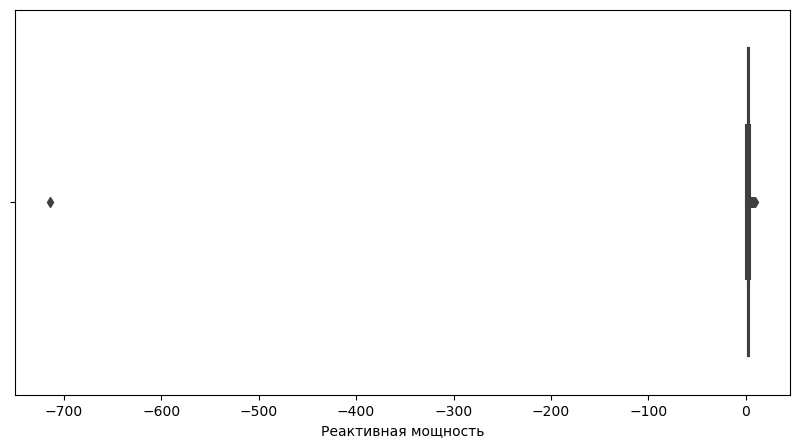

In [15]:
plt.figure(figsize=(10, 5))
sns.boxplot(data_full['Реактивная мощность'])
plt.show()

In [16]:
data_full = data_full[data_full['Реактивная мощность'] > 0]

/home/brshk-shaun/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


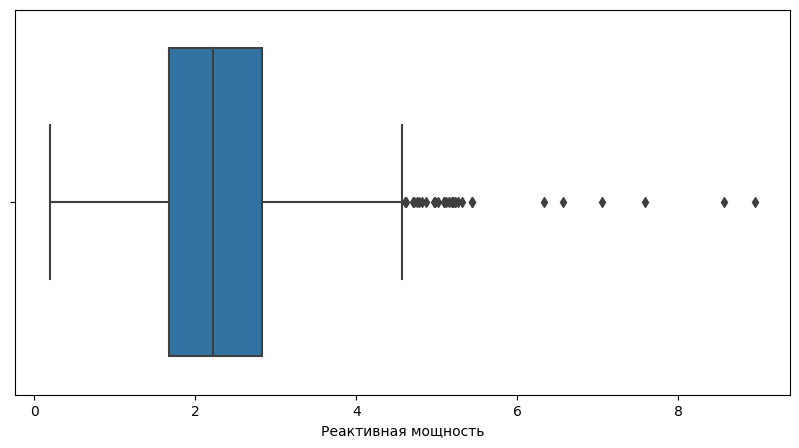

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(data_full['Реактивная мощность'])
plt.show()

### Сыпучие материалы
На графике можем увидеть, что некоторые даннные встречаются совсем уж редко, однако, не будем спешить удалять признак

<AxesSubplot:>

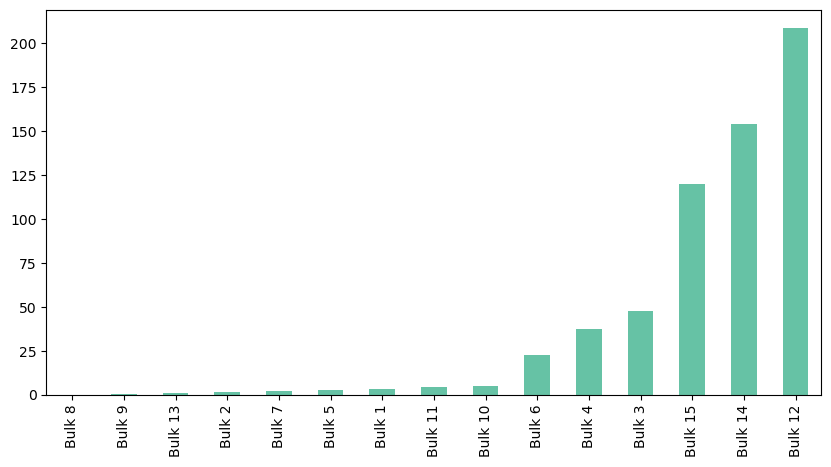

In [18]:
plt.figure(figsize=(10, 5))
(data_full.iloc[:, 10:25].mean().sort_values()).plot(kind='bar', cmap='Set2')

### Проволочные материалы
Тоже есть данные, которые встречаются очень редко, пока не будем трогать

<AxesSubplot:>

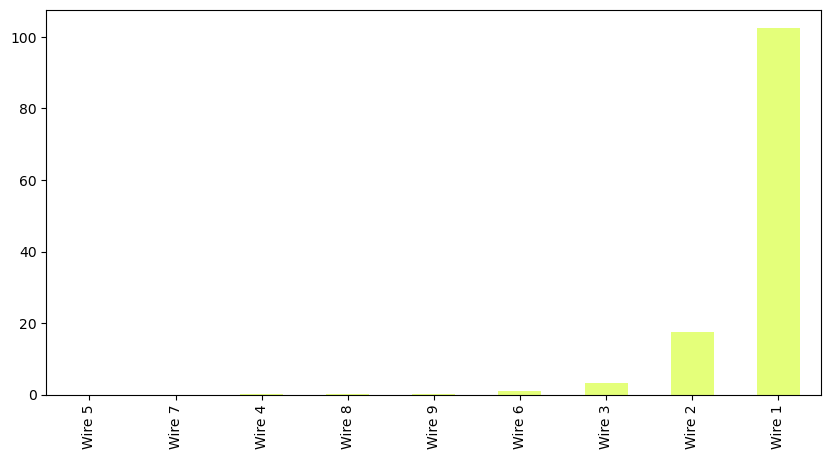

In [19]:
plt.figure(figsize=(10, 5))
(data_full.iloc[:, 25:].mean().sort_values()).plot(kind='bar', cmap='Wistia')

### Корреляция признаков
На данной таблице мы видим, что один признак вообще коррелируется с ошибкой (НаН), в дальнейшем удалим его.
Также удалим признак "Реактивная мощность", т.к. он сильно коррелирует с другими.
Кроме этого удалим Bulk 7 *(у меня нет объяснения, коррелирует не больше других, но его отсутствие улучшает метрику)*.

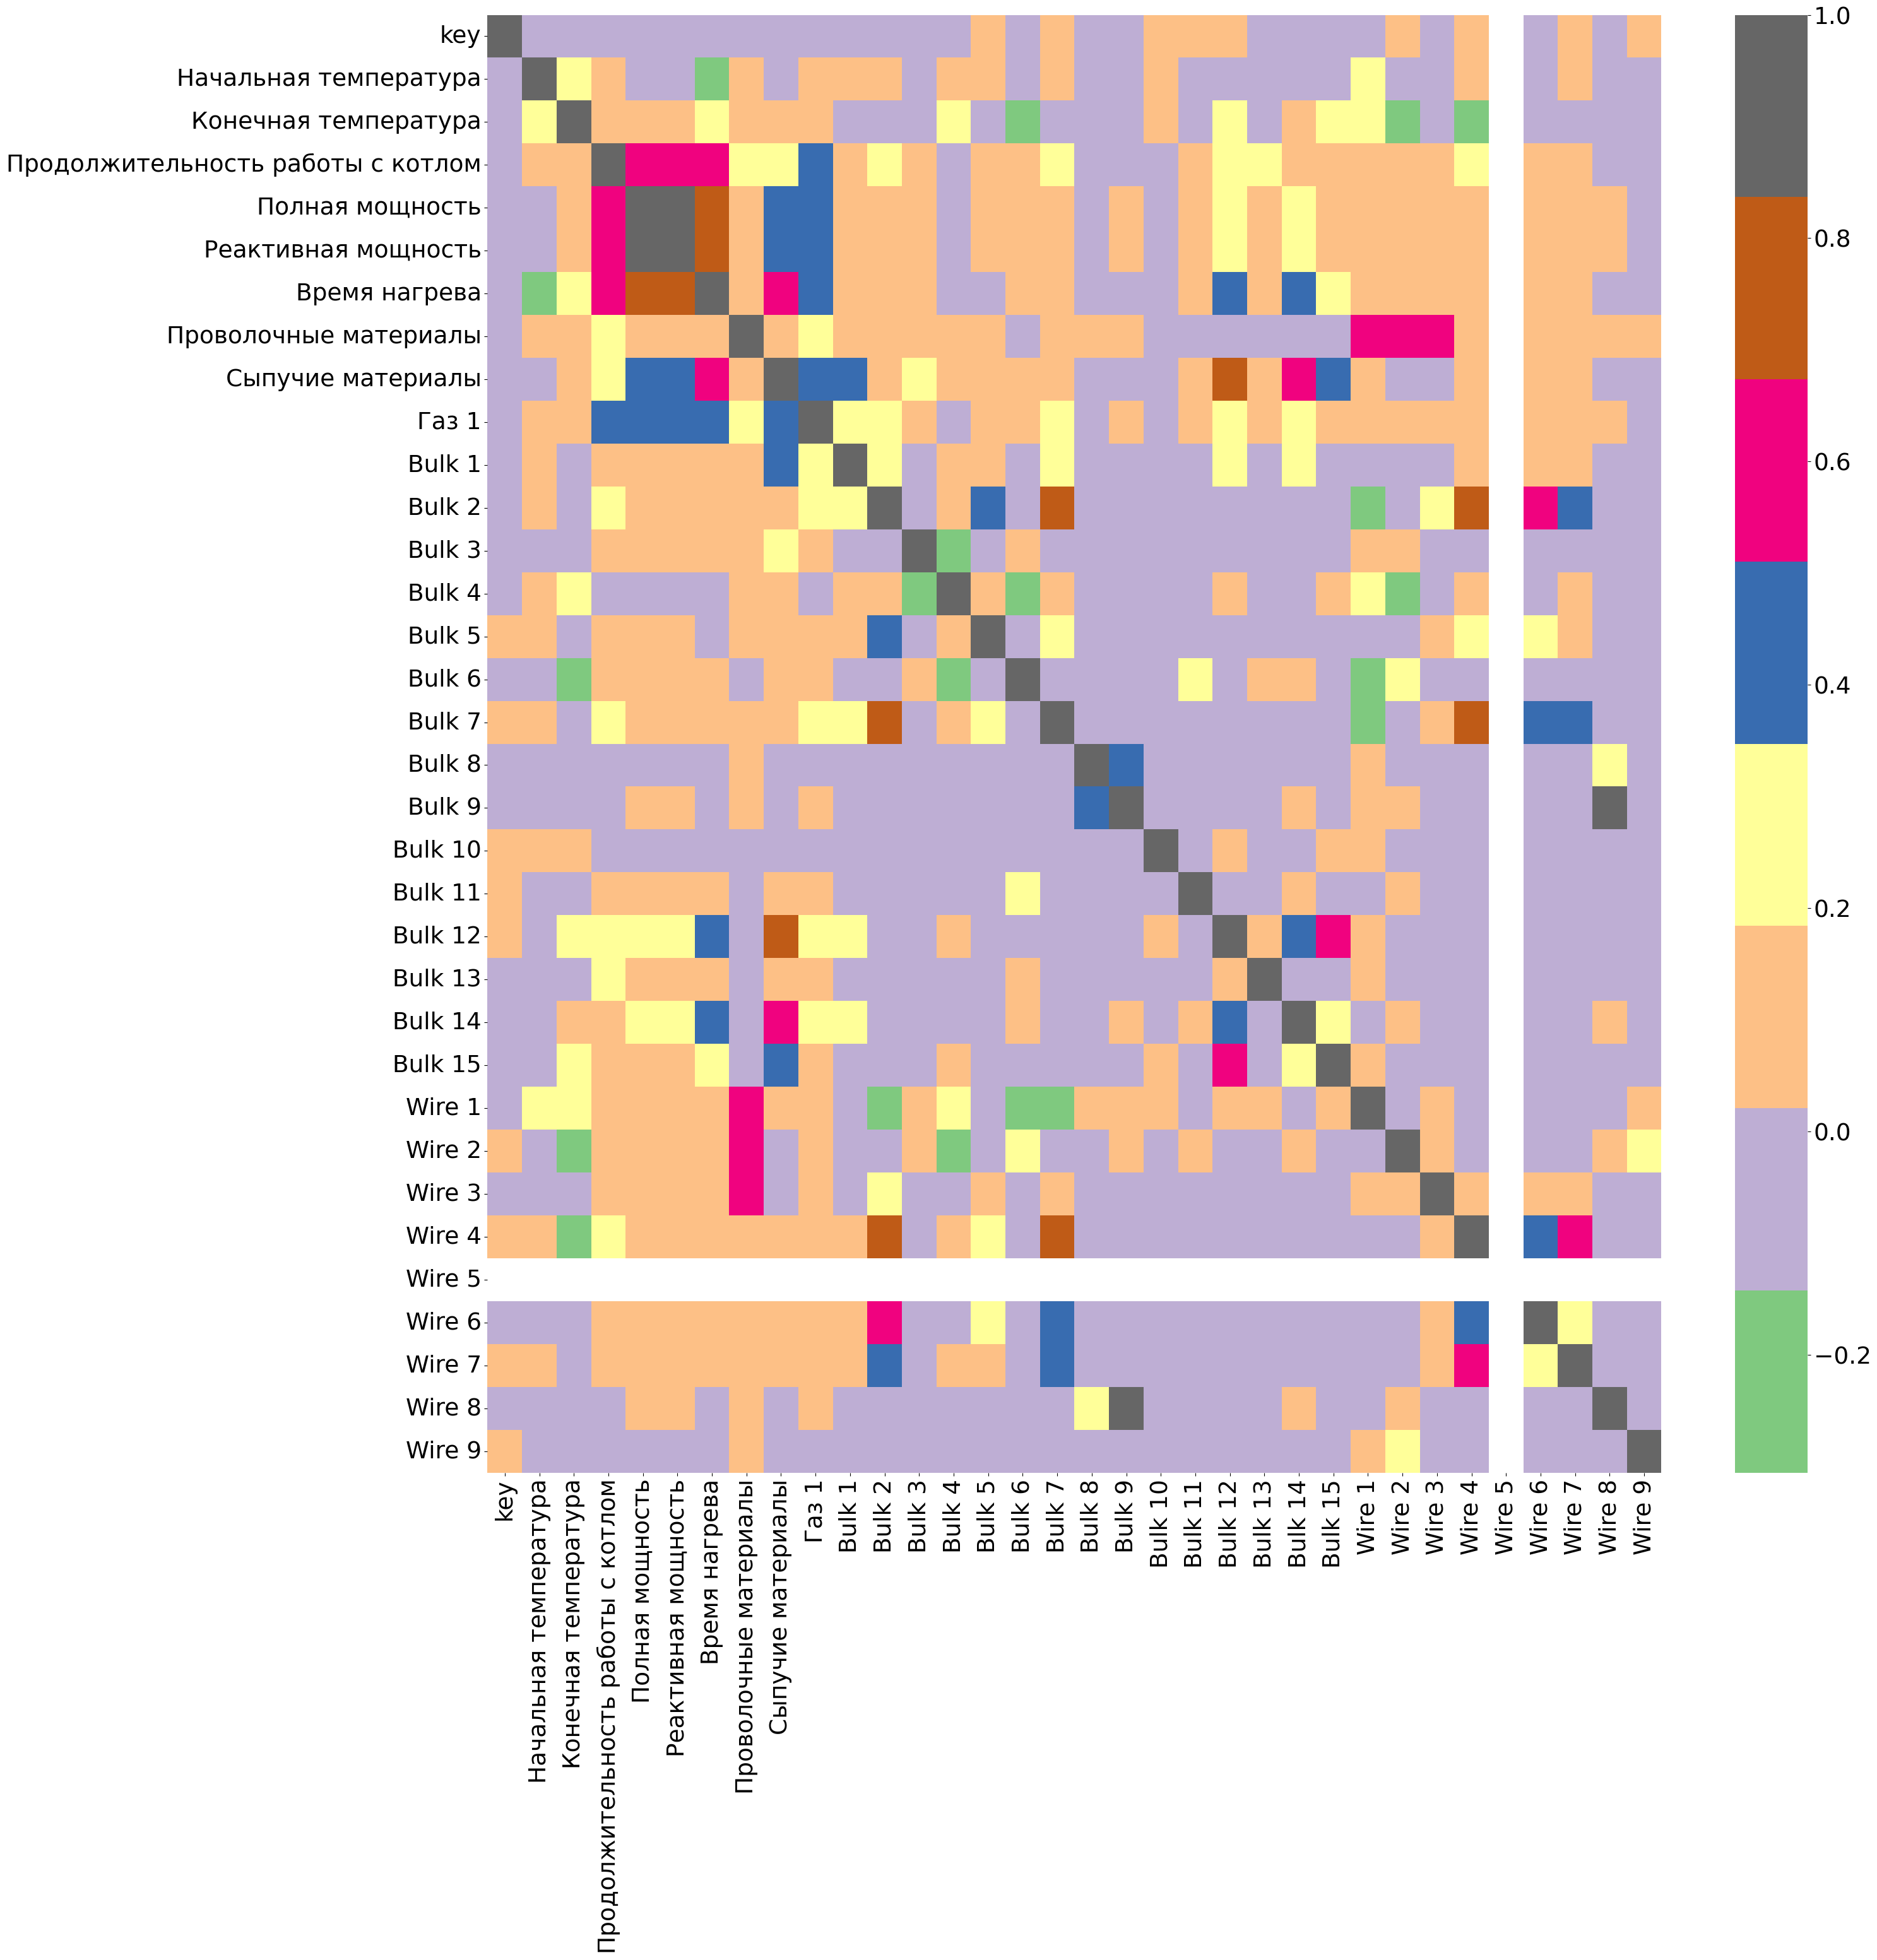

In [20]:
plt.figure(figsize=(30, 30))
plt.rcParams['font.size'] = '27'
sns.heatmap(data_full.corr(), cmap="Accent", annot=False)
plt.show()

In [21]:
data_full = data_full.drop(['key'], axis=1)
data_full = data_full.drop(['Wire 5'], axis=1)
data_full = data_full.drop(['Bulk 7'], axis=1)
data_full = data_full.drop(['Реактивная мощность'], axis=1)

data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Начальная температура              2328 non-null   float64
 1   Конечная температура               2328 non-null   float64
 2   Продолжительность работы с котлом  2328 non-null   float64
 3   Полная мощность                    2328 non-null   float64
 4   Время нагрева                      2328 non-null   float64
 5   Проволочные материалы              2328 non-null   float64
 6   Сыпучие материалы                  2328 non-null   float64
 7   Газ 1                              2328 non-null   float64
 8   Bulk 1                             2328 non-null   float64
 9   Bulk 2                             2328 non-null   float64
 10  Bulk 3                             2328 non-null   float64
 11  Bulk 4                             2328 non-null   float

На этом этапе наша предобработка завершается.

**Вывод:**

* данные содержат много пропусков
* очевидные выбросы не так часто попадают, что несмоненный плюс
* некоторые ключи из первоначальной таблицы построенной нами отсутствуют в других таблицах, значит либо отстутсвует четкая норма фиксирования всех данных по ковшу, либо частично данные утеряны до передачи
* существует необходимость создания дополнительных признаков для улучшения качества работы модели

In [22]:
data_full

,Начальная температура,Конечная температура,Продолжительность работы с котлом,Полная мощность,Время нагрева,Проволочные материалы,Сыпучие материалы,Газ 1,Bulk 1,Bulk 2,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,1714.0,3.716640,1098.0,60.059998,399.0,29.749986,0.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,1265.0,2.586371,811.0,96.052315,428.0,12.555561,0.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,1753.0,5.014163,655.0,91.160157,391.0,28.554793,0.0,0.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,1220.0,3.399456,741.0,89.063515,441.0,18.841219,0.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,1536.0,2.815155,869.0,98.352796,432.0,5.413692,0.0,0.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,1380.0,3.863328,723.0,89.150879,496.0,7.125735,0.0,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2325,1554.0,1591.0,1705.0,5.067396,940.0,114.179527,570.0,9.412616,0.0,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2326,1571.0,1589.0,962.0,4.360104,569.0,103.134723,439.0,6.271699,0.0,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2327,1591.0,1594.0,1520.0,3.907887,750.0,118.110717,526.0,14.953657,0.0,0.0,...,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


## Моделирование

### Линейная регрессия
Для начала разделим признаки и проверим метрику на самой базовой модели - Линейной регрессии.

In [23]:
features = data_full.drop(['Конечная температура'], axis=1)
target = data_full['Конечная температура']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, target,
                                                            test_size=0.25,
                                                            random_state=RANDOM_STATE,
                                                            shuffle=True)

print(features_train.shape, features_test.shape)

model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_test)

print(mean_absolute_error(target_test, predict))

(1746, 29) (582, 29)
6.63633527914538


### Решающее дерево
Для запуска подбора параметров на этой модели создадим свой оценщик и с помощью GridSearch проведем подбор параметров методом кросс-валидации

In [24]:
mae = make_scorer(mean_absolute_error, greater_is_better=False)

params_forest = {
    'n_estimators': range(5, 50, 5),
    'max_depth': range(5, 25, 5),
    'random_state': [RANDOM_STATE]
#     'criterion': ['absolute_error'] этот параметр у меня крашится на платформе, дома работает
}

forest = GridSearchCV(RandomForestRegressor(), params_forest, scoring=mae, verbose=1)
forest.fit(features_train, target_train)

print('Best score:', forest.best_score_, '\nBest parameters:', forest.best_params_,
       '\nFit time:', forest.refit_time_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: -6.138960413227583 
Best parameters: {'max_depth': 15, 'n_estimators': 45, 'random_state': 80523} 
Fit time: 0.42000532150268555


### Бустинг
Попробуем смоделировать прогнозы на модели бустинга - Catboost.
Также через GridSearch подберем лучшие параметры.

In [25]:
params_cat = {
    'loss_function': ['MAE'],
    'l2_leaf_reg': [4, 5],
    'random_state': [RANDOM_STATE]
}

catboost = GridSearchCV(CatBoostRegressor(), params_cat, scoring=mae)
catboost.fit(features_train, target_train)

print('Best score:', catboost.best_score_, '\nBest parameters:', catboost.best_params_,
       '\nFit time:', catboost.refit_time_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best score: -5.911114816135143 
Best parameters: {'l2_leaf_reg': 4, 'loss_function': 'MAE', 'random_state': 80523} 
Fit time: 0.8960769176483154


### Важность признаков
Посмотрим на график важности признаков у решающего дерева и бустинга.
Как видим, некоторые признаки совсем слабо влияют. Возможно, их удаление ускорит работу модели. *(но мы удалять не будем, т.к. метрика падает)*

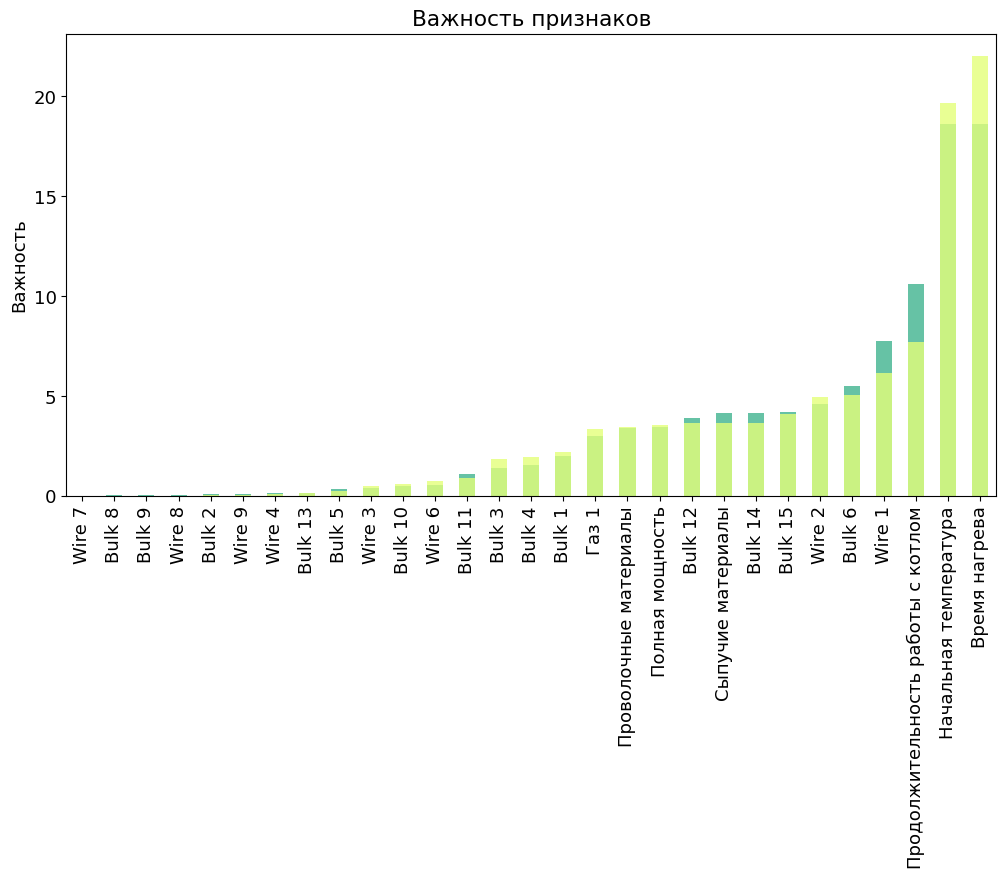

In [26]:
importance_cat = pd.Series(catboost.best_estimator_.feature_importances_,
                         features.columns).sort_values()
importance_forest = pd.Series(forest.best_estimator_.feature_importances_ * 100,
                         features.columns).sort_values()


plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '13'
importance_forest.plot.bar(cmap='Set2')
importance_cat.plot.bar(cmap='Wistia',alpha=0.8)
plt.title("Важность признаков")
plt.ylabel('Важность')
plt.show()

### Финальное предсказание

In [27]:
predict = catboost.best_estimator_.predict(features_test)
print(mean_absolute_error(target_test, predict))

5.937748352072695


Модель бустинга Catboost показала наилучший результат, именно поэтому финальное предсказание выполняем на ней.

Значение МАЕ на тестовой выборке - 5.93

## Отчет

Работа была сформирована по следующему плану:

1. Инструкция
2. Загрузка данных
3. Обработка данных
4. Исследование данных
5. Моделирование

**Инструкция:**

На данном этапе было загружено описание работы, ТЗ и описание данных.

**Загрузка данных:**

Здесь были загружены все файлы для дальнейшей работы, проведен первичный осмотр.

**Обработка данных:**

Этап обработки данных можно считать самым оригинальным, т.к. вся подготовка данных выполнялась точечно, в соответсвии с дальнейшей задачей и особенностями стартовых датасетов. Сама обработка заключалась в создании новой таблицы признаков, куда загружались только те данные, которые существовали во всех других таблицах. Таким образом нам удалось сформировать четкие признаки по 2328 котлам. Основным признаком явлись ключ - уникальный номер котла, начальная температура стали и конечная температура стали - это признак мы в дальнейшем предсказывали с помощью моделей. Остальные признаки были либо добавлены из уже существующих датасетов (*Bulk 1, Wire 1, Газ 1, etc.*), либо сформированы вручную (*Время работы с котлом, Время нагрева, Суммарные количества сыпучих и проволочных материалов, Работа*).

* *Трудности:*

Основными трудностями данного этапа можно считать несформированность начальных датасетов в единый, отсутсвие данных по некоторым котлам во всех таблицах, пропуски (*NaN*), несоответсвие данных нужному типу.

**Исследование данных**:

Этап исследования данных включал в себя графический анализ сформированных в единый датафрейм данных. На данном этапе были устранены явные выбросы - температура в котле ниже *1450 градусов* и реактивная мощность *-700*. Также был проведен графический анализ корреляции признаков, с помощью которого был удален признак, с отстутствующей информацией, а также признак реактивной мощности и работа. Кроме этого, был проведен графический анализ общего количества данных в признаках *Bulk и Wire.*

* *Трудности:*

Реальных трудностей в этом пункте не встретилось, однако, из-за большого количества признаков был затруднен анализ графического изображения корреляции. Для решения проблемы была выбрана яркая и достаточно контрастная палитра цветов, а также увеличен размер шрифта. Кроме этого при графическом анализе начальной температуры было обнаружено не нормальное распределение - о чем сведетельствуют 3 пика на графике. В связи с таким разбросом данных модель неизбежно будет ошибаться на данных котлах.

**Моделирование**:

Моделирование включало разбиение датафрейма с целью отделить целевой признак и разбить данные на две выборки, а также создание трех моделей: линейная регрессия, решающее дерево и бустинг. Самой быстрой, но самой неточной моделью, ождидаемо, является модель регрессии. Для остальных моделей были подобраны лучшие параметры с помощью кросс-валидации GridSearch. Для оценки предсказаний была выбрана метрика МАЕ - mean absolute error (*средняя абсолютная ошибка, MAE = (1/n) Σ(i=1 to n) |y_i – ŷ_i|*). Также для моделей был выведен график важности признаков. Самой точной в соответсвии с метрикой оказалась модель бустинга -  *Catboost*. Именно поэтому финальное предсказание на тестовой выборке данных проводилось на ней. Итоговое значение МАЕ составило *5.93*.

* *Трудности:*
Основной трудностью являлось возвращение к предыдущим этапам для формирования признаков с наименьшим возможным МАЕ

**Гиперпараметры Catboost:**
* 'l2_leaf_reg': 4
* 'loss_function': 'MAE'
* 'random_state': 80523
* остальные гиперпараметры по умолчанию

**Признаки, используемые для обучения моделей:**
 *  Начальная температура              
 *  ***Конечная температура*** - именно этот признак являлся целевым для предсказаний моделей              
 *  Продолжительность работы с котлом  
 *  Полная мощность                    
 *  Время нагрева                      
 *  Проволочные материалы              
 *  Сыпучие материалы                  
 *  Газ 1                              
 *  Bulk 1                             
 *  Bulk 2                             
 *  Bulk 3                             
 *  Bulk 4                            
 *  Bulk 5                             
 *  Bulk 6                             
 *  Bulk 8                            
 *  Bulk 9                             
 *  Bulk 10                           
 *  Bulk 11                           
 *  Bulk 12                            
 *  Bulk 13                            
 *  Bulk 14                            
 *  Bulk 15                            
 *  Wire 1                             
 *  Wire 2                             
 *  Wire 3                             
 *  Wire 4                            
 *  Wire 6                             
 *  Wire 7                             
 *  Wire 8                             
 *  Wire 9  
 
**Рекомендации для улучшения модели:**

Для улучшения работы модели необходимо строго регламентировать время первичного и последнего замера. Важно избежать разброса данных в первичной температуре, это поможет улучшить метрику почти в два раза.

Также для создания новых признаков, возможно, стоит дать четкое соотношение мматериалов при добавлении сыпучих веществ. Таким образом, каждая группа при разных соотношениях может дать необходимую информацию для моделии также улучшить ее метрику.

Кроме этого важно точно вести запись указанных выше параметров по каждому котлу, избегать пропусков. В таком случае мы будем иметь больше данных для работы, что тоже улучшит обучаемость модели.  